# 2. Dataset description
### NIH Chest X-ray Dataset

## Problem

Chest X-ray exams are among the most commonly conducted and least expensive imaging procedures available today.
However, the clinical diagnosis of a chest radiograph is complicated and often more complex than a chest CT scan.
To a large degree, clinical identification and evaluation is yet unachievable due to the lack of widely accessible datasets for chest X-rays. Once you have a huge dataset of X-ray files, you're usually left lacking in resources to mark it.
Prior to the availability of this dataset, the number of publicly accessible X-ray images was 4,143.

## Dataset

This NIH dataset consist of 112,120 disease labels from 3,805 unique patients with size 1024 x 1024.

Image labels may contain some inaccuracies, but the estimated NLP labeling accuracy is determined to be higher than 90%.


**BBox_list_2017.csv: **Bounding box coordinates. Note: Start at x,y, extend horizontally w pixels, and vertically h pixels

- Image Index: File name
- Finding Label: Disease type (Class label)
- Bbox x
- Bbox y
- Bbox w
- Bbox h


**Data_entry_2020.csv:** Class labels and patient data for the entire dataset
- Image Index: File name
- Finding Labels: Disease type (Class label)
- Follow-up #
- Patient ID
- Patient Age
- Patient Gender
- View Position: X-ray orientation
- OriginalImageWidth
- OriginalImageHeight
- OriginalImagePixelSpacing_x
- OriginalImagePixelSpacing_y


**Class descriptions**

There are 15 classes (14 diseases, and one for "No findings" or normal). Images can be classified as "No findings" or one or more disease classes:

- Atelectasis
- Consolidation
- Infiltration
- Pneumothorax
- Edema
- Emphysema
- Fibrosis
- Effusion
- Pneumonia
- Pleural_thickening
- Cardiomegaly
-  Nodule Mass
-  Hernia


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')

## Loading the data

In [5]:
dir = '/groups/jjrodrig/projects/chest/dataset/nih/'
all_data       = pd.read_csv(dir + '/files/Data_Entry_2017_v2020.csv')
test_list      = pd.read_csv(dir + '/files/test_list.txt',names=['Image Index'])

all_data.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1                        0.143  0.143  
2                        0.168  0.168  
3                        0.171  0.171  
4                        0.168  0.168

In [6]:
print('shape of data : ',all_data.shape)

shape of data :  (112120, 11)


In [7]:
all_data.describe()

Follow-up #     Patient ID    Patient Age  OriginalImage[Width  \
count  112120.000000  112120.000000  112120.000000        112120.000000   
mean        8.573751   14346.381743      46.626365          2646.078844   
std        15.406320    8403.876972      16.602680           341.246429   
min         0.000000       1.000000       0.000000          1143.000000   
25%         0.000000    7310.750000      34.000000          2500.000000   
50%         3.000000   13993.000000      49.000000          2518.000000   
75%        10.000000   20673.000000      59.000000          2992.000000   
max       183.000000   30805.000000      95.000000          3827.000000   

             Height]  OriginalImagePixelSpacing[x             y]  
count  112120.000000                112120.000000  112120.000000  
mean     2486.438842                     0.155649       0.155649  
std       401.268227                     0.016174       0.016174  
min       966.000000                     0.115000       0.115000  
25%      2048.000000                     0.143000       0.143000  
50%      2544.000000                     0.143000       0.143000  
75%      2991.000000                     0.168000       0.168000  
max      4715.000000                     0.198800       0.198800

<h2> 3.2 Data cleaning </h2>

In [6]:
#drop unused columns
data = all_data[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

# removing the rows which have patient_age >100
total = len(data)
print('No. of rows before removing rows having age >100 : ',len(data))
data = data[data['Patient Age']<100]
print('No. of rows after removing rows having age >100 : ',len(data))
print('No. of datapoints having age > 100 : ',total-len(data))

No. of rows before removing rows having age >100 :  112120
No. of rows after removing rows having age >100 :  112104
No. of datapoints having age > 100 :  16


In [7]:
# rows having no. of disease
data['Labels_Count'] = data['Finding Labels'].apply(lambda text: len(text.split('|')) if(text != 'No Finding') else 0)

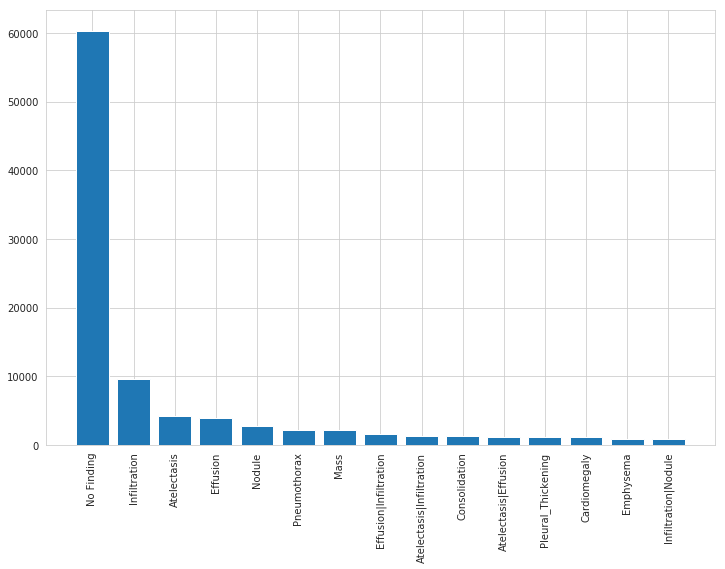

In [8]:
label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

<h2> 3.3 Data analysis </h2>

<h3> 3.3.1 Age distribution </h3>

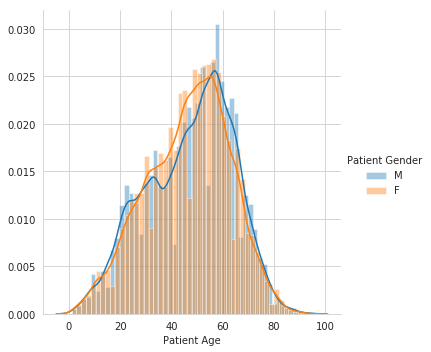

In [9]:
#plt.figure(figsize=(20,15))
sns.FacetGrid(data,hue='Patient Gender',size=5).map(sns.distplot,'Patient Age').add_legend()
plt.show()

#### Observation - Both the gender have almost same distribution

<h3> 3.3.2 Disease distribution by age and sex </h3>

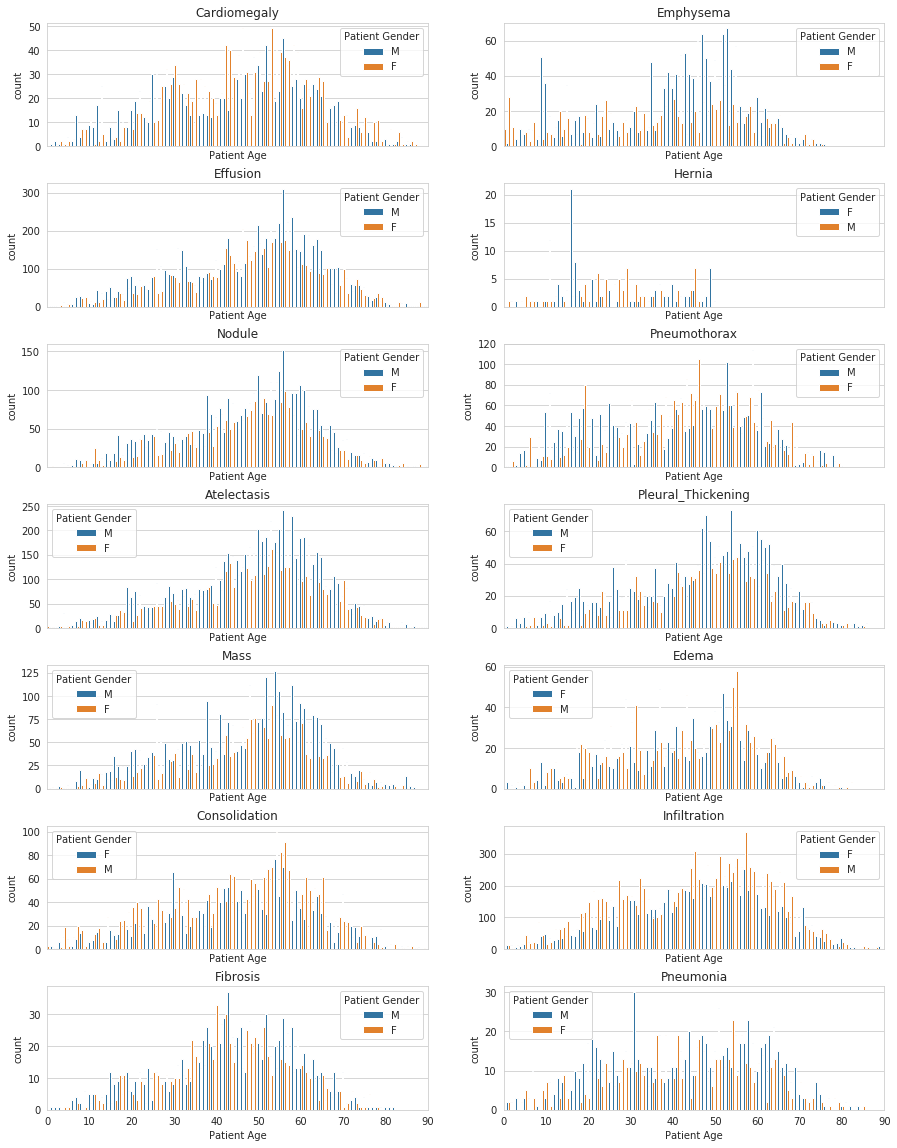

In [11]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
df = data[data['Finding Labels'] != 'No Finding']
i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    index = []
    for k in range(len(df)):
        if pathology in df.iloc[k]['Finding Labels']:
            index.append(k)
    g=sns.countplot(x='Patient Age', hue="Patient Gender",data=df.iloc[index], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

<h3> 3.3.3 No. of each disease by patient gender </h3>

In [12]:
for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

In [13]:
data.head()

Image Index          Finding Labels    ...      Fibrosis  Pneumonia
0  00000001_000.png            Cardiomegaly    ...             0          0
1  00000001_001.png  Cardiomegaly|Emphysema    ...             0          0
2  00000001_002.png   Cardiomegaly|Effusion    ...             0          0
3  00000002_000.png              No Finding    ...             0          0
4  00000003_000.png                  Hernia    ...             0          0

[5 rows x 21 columns]

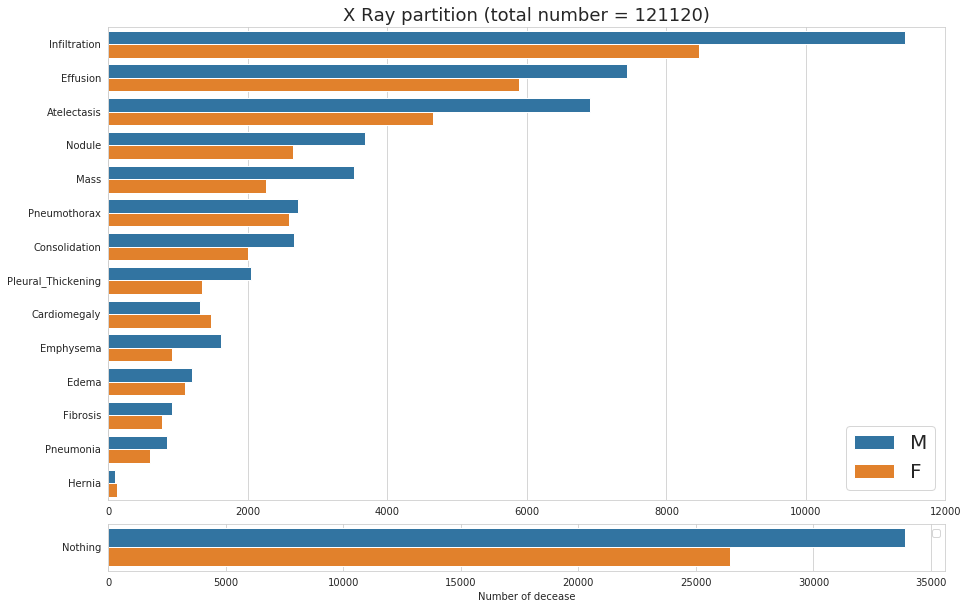

In [14]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(data,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

data['Nothing']=data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(data,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

<h3> 3.3.5 ratio between one and multiple disease </h3>

In [16]:
df=data.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=df[['|' in index for index in df.index]].copy()
df2=df[['|' not in index for index in df.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

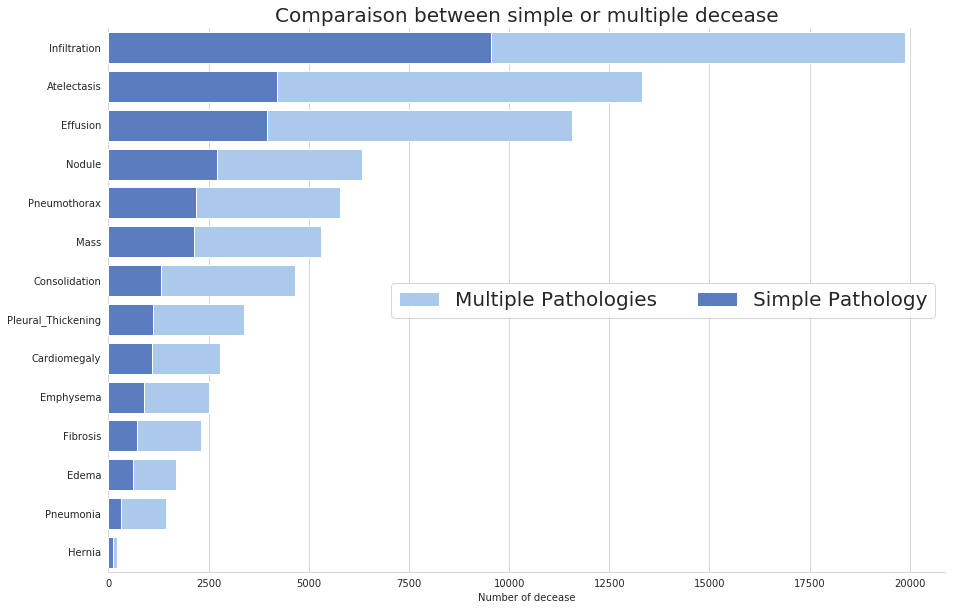

In [17]:
f, ax = plt.subplots(sharex=True,figsize=(15, 10))
sns.set_color_codes("pastel")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="b",label="Simple Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Comparaison between simple or multiple decease",fontsize=20)      
sns.despine(left=True)

<h3> 3.3.6 Plot most important pathologies groups for each desease </h3>

In [18]:
#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in pathology_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head(20)

Patient ID    ...    Pneumonia
Finding Labels                                   ...             
Effusion|Infiltration                    1603    ...            0
Atelectasis|Infiltration                 1350    ...            0
Atelectasis|Effusion                     1165    ...            0
Infiltration|Nodule                       829    ...            0
Atelectasis|Effusion|Infiltration         737    ...            0
Cardiomegaly|Effusion                     484    ...            0
Consolidation|Infiltration                441    ...            0
Infiltration|Mass                         418    ...            0
Effusion|Pneumothorax                     403    ...            0
Effusion|Mass                             402    ...            0
Atelectasis|Consolidation                 398    ...            0
Mass|Nodule                               394    ...            0
Edema|Infiltration                        392    ...            0
Infiltration|Pneumothorax                 345    ...            0
Consolidation|Effusion                    337    ...            0
Emphysema|Pneumothorax                    337    ...            0
Effusion|Pleural_Thickening               251    ...            0
Effusion|Nodule                           249    ...            0
Atelectasis|Pneumothorax                  240    ...            0
Infiltration|Pleural_Thickening           210    ...            0

[20 rows x 16 columns]